# NLP - Traitement Automatique du Langage Naturel

Notre librarie de code préférée pour le traitement du langage naturel est [SpaCy](../tools/spacy.ipynb), et nous lui avons d'ailleurs dédié un bloc-note Jupyter qui démontre les bases.

Les [transformers](https://arxiv.org/abs/1706.03762) ont changé les paradigmes du traitement du langage naturel. Il existe de nombreux modèles anglais et multilingues, mais peu de modèles français, l'inconvénient des modèles multilingues étant principalement leur taille, et accessoirement les faiblesses de la part du corpus d'entrainement dédiée au français. Nous avons donc souhaité rendre ici hommage aux rares modèles dédiés au français, que sont [Camembert](https://huggingface.co/almanach), [Croissant](https://huggingface.co/croissantllm), [Flaubert](https://huggingface.co/flaubert), [Vigogne](https://huggingface.co/bofenghuang), et bientôt Lucie.

[![Index](https://img.shields.io/badge/Index-blue)](../index.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/digillia/Digillia-Colab/blob/main/algorithms/nlp-basics.ipynb)

In [1]:
import os
import sys

# Supprimer les commentaires pour installer (requirements.txt)
# !pip3 install -q -U beautifulsoup4
# !pip3 install -q -U matplotlib
# !pip3 install -q -U nltk
# !pip3 install -q -U torch
# !pip3 install -q -U transformers

# À installer dans tous les cas pour Google Colab et Github
if 'google.colab' in sys.modules or 'CI' in os.environ:
    #!pip3 install -q -U accelerate # requis par Croissant (device_map="auto")
    !pip3 install -q -U scipy==1.12.0 # https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-gensim
    !pip3 install -q -U gensim
    !pip3 install -q -U Pattern
    !pip3 install -q -U wordcloud
    !pip3 install -q -U sentencepiece # requis par Camembert
    !pip3 install -q -U sacremoses # requis par Flaubert

In [3]:
# Les variables python sont accessibles depuis les commandes shell
work_directory = './nlp-basics'

!mkdir -p $work_directory

## NLTK

Nous préférons [SpaCy](../tools/spacy.ipynb) à NLTK en français, mais c'est ici l'occasion d'en faire une rapide démonstration et d'en soulever les limitations.

In [4]:
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import FrenchStemmer
from nltk.tag import StanfordPOSTagger
from nltk.corpus import stopwords
from pattern.fr import parse as pattern_parse
from gensim.models import KeyedVectors

nltk.download('punkt') # pour la tokenisation en français
nltk.download('stopwords') # pour les stopwords

ModuleNotFoundError: No module named 'pattern'

In [ ]:
language = 'french'
text = 'Les deux petites chiennes courent après la balle.'

### Tokenisation

La tokenisation consiste à découper un texte en unités plus petites, appelées tokens, qui peuvent ensuite être traitées par des modèles d'apprentissage automatique de traitement du langage naturel.

In [ ]:
doc = word_tokenize(text, language=language)
for word in doc:
    print(word)

Les
deux
petites
chiennes
courent
après
la
balle
.


### Lemmatisation

La lemmatisation consiste à réduire un mot à sa forme de base, appelée “lemme”. Contrairement à la stemmatisation qui produit une racine cardinale, le lemme est généralement un mot du dictionnaire qui représente le mot commun d'origine. Par exemple, le lemme de l'adjectif “petite” est “petit”.

Pour la langue française, il n'est pas possible d'utiliser `nltk.stem.WordNetLemmatizer`. On peut utiliser [TreeTagger](https://treetaggerwrapper.readthedocs.io), ou comme [TextBlob](https://github.com/sloria/TextBlob): [Pattern](https://pypi.org/project/Pattern/).

In [ ]:
# Stematisation
stemmer = FrenchStemmer()
for word in doc:
    print(word, '->', stemmer.stem(word))

Les -> le
deux -> deux
petites -> petit
chiennes -> chien
courent -> courent
après -> apres
la -> la
balle -> ball
. -> .


In [ ]:
# Lemmatisation
def pattern_stopiteration_workaround():
    # Fixes RuntimeError: generator raised StopIteration
    # Check https://stackoverflow.com/a/67544967
    try:
        pattern_parse('bonjour', lemmata=True, tags=False, chunks=False)
    except StopIteration:
        pass

pattern_stopiteration_workaround()
lemmatized_doc = pattern_parse(text, lemmata=True, tags=False, chunks=False).split()[0]
for lem in lemmatized_doc:
    print(lem[0], '->', lem[2])

ModuleNotFoundError: No module named 'pattern'

### Étiquetage grammatical

Le Part-of-Speech Tagging (ou étiquetage grammatical en français) essaye d’attribuer une étiquette à chaque mot d’une phrase représentant la classe grammaticale de ce mot (nom propre, adjectif, verbe, etc).

Pour la langue française, il n'est pas possible d'utiliser `nltk.pos_tag`. Nous pourrions utiliser [Pattern](https://pypi.org/project/Pattern/), mais nous avons choisi d'utiliser [Stanford Core NLP](https://stanfordnlp.github.io/CoreNLP/).

In [ ]:
# Récupération des données (notamment pour Google Colab)
!curl --create-dirs -O --output-dir $work_directory "https://downloads.cs.stanford.edu/nlp/software/stanford-tagger-4.2.0.zip"

# Décompression du fichier
# La commande tar ne permet pas de dézipper sur Google Colab, contrairement à MacOS et Windows
# !tar -xvf $work_directory/stanford-tagger-4.2.0.zip -C $work_directory
from zipfile import ZipFile
with ZipFile(f'{work_directory}/stanford-tagger-4.2.0.zip', 'r') as ZipObj:
  ZipObj.extractall(work_directory)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 74.4M  100 74.4M    0     0  6168k      0  0:00:12  0:00:12 --:--:-- 5261k00:01  0:00:33 2230k


In [ ]:
# Ceci suppose que Java ait été installé et que la variable d'environnement JAVA_HOME ait été définie
# https://nlp.stanford.edu/software/tagger.shtml
jar = f'{work_directory}/stanford-postagger-full-2020-11-17/stanford-postagger-4.2.0.jar'
model = f'{work_directory}/stanford-postagger-full-2020-11-17/models/french-ud.tagger'
pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8')
tags = pos_tagger.tag(doc)
for tag in tags:
  print(tag[0], '->', tag[1])

NameError: name 'work_directory' is not defined

### Stop words

Les stop words sont un ensemble de mots couramment utilisés qui n’apportent pas d’information pour comprendre le sens du texte, comme le, la, un, une, etc. En traitement du langage natural, on cherche souvent à les éliminer pour se concentrer sur les mots riches de sens.

In [ ]:
STOP_WORDS = stopwords.words('french')

meaningful_words = []
for word in doc:
    if word not in STOP_WORDS:
        meaningful_words.append(word)
meaningful_words

['Les', 'deux', 'petites', 'chiennes', 'courent', 'après', 'balle', '.']

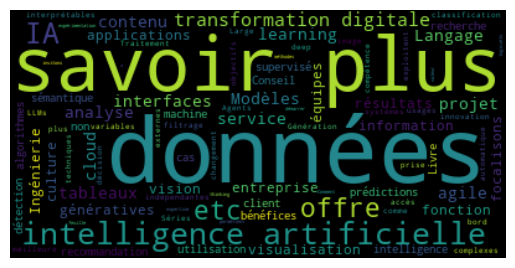

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from urllib.request import urlopen

with urlopen('https://www.digillia.com') as response:
    soup = BeautifulSoup(response, 'html.parser')
    STOP_WORDS.extend(['d', 'l', 'Digillia'])
    wc = WordCloud(stopwords = STOP_WORDS, collocations=True).generate(soup.get_text())
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Plongement lexical

Le Word Embedding (ou plongement lexical en français) est une méthode d'encodage qui vise à représenter les mots ou les phrases d’un texte par des vecteurs de nombres réels pour localiser ces mots dans un espace multi-dimensionnel (ou Vector Space Model), notamment à des fins de comparaison.

In [ ]:
# Récupération des fichiers Word2Vec pré-entraînés (notamment pour Google Colab et Github)
# Les deux premiers sont très gros et très lents à charger
# !curl --create-dirs -O --output-dir $work_directory "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz"
# !curl --create-dirs -O --output-dir $work_directory "http://wikipedia2vec.s3.amazonaws.com/models/de/2018-04-20/dewiki_20180420_100d.txt.bz2"
!curl --create-dirs -O --output-dir $work_directory "https://embeddings.net/embeddings/frWiki_no_phrase_no_postag_500_cbow_cut10.bin"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  128M  100  128M    0     0  9790k      0  0:00:13  0:00:13 --:--:-- 8695k  0  0:00:07  0:00:02  0:00:05 16.1M


In [ ]:
# Chemin vers le fichier de modèle Word2Vec pré-entraîné en français
# model_path = f'{work_directory}/fasttext_embeddings_fr.vec.gz'
# model_path = f'{work_directory}/2018-04-20/dewiki_20180420_100d.txt.bz2'
# binary = False
# Le fichier ci-dessous est binaire contrairement aux deux premiers
model_path = f'{work_directory}/frWiki_no_phrase_no_postag_500_cbow_cut10.bin'
binary = True

# Charger le modèle Word2Vec pré-entraîné en français
model = KeyedVectors.load_word2vec_format(model_path, binary=binary)

# Afficher le vecteur pour un mot spécifique
word = meaningful_words[1]
print(word, '->', model[word])

deux -> [-1.43188223e-01 -1.55123323e-01 -1.76652208e-01  5.67114651e-01
  9.07518193e-02  2.28723213e-01  2.31655151e-01 -2.32938692e-01
 -2.53074430e-02  1.54531166e-01 -3.96100469e-02  1.26164243e-01
  6.94181323e-02  5.24218380e-01  3.10593098e-01  2.57824630e-01
 -4.10055935e-01 -1.20233342e-01 -4.35307235e-01 -3.54416639e-01
  4.24476385e-01 -2.91272223e-01 -3.28398615e-01  2.85763472e-01
  1.05614260e-01 -3.42503577e-01  1.49135128e-01 -4.43803817e-01
  1.32804051e-01 -2.07508102e-01 -9.21434015e-02 -1.36090532e-01
  1.18885562e-01  7.90397525e-02 -9.47980136e-02  8.97164717e-02
 -1.24256879e-01  2.32379541e-01 -1.85206234e-01  1.31950364e-01
  3.61383170e-01 -5.95386207e-01 -6.66764736e-01 -4.81542081e-01
 -4.25538830e-02  1.99623391e-01  1.41170412e-01  5.74456826e-02
  2.57270038e-02  1.19005106e-01 -1.62516043e-01  6.79081902e-02
  1.58047993e-02  1.71319157e-01  3.36675867e-02 -2.08640471e-01
  1.69163570e-01  2.97450304e-01  3.39881241e-01  3.18871677e-01
 -2.53713310e-01 

### Similarités

La représentation en vecteurs permet de mesurer la similarité par cosinus.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

word1 = 'chien'
word2 = 'cheval'
word3 = 'voiture'
word4 = 'automobile'

print(word1, word2, model.similarity(word1, word2))
print(word3, word4, model.similarity(word3, word4))
print(word1, word3, model.similarity(word1, word3))

chien cheval 0.31312007
voiture automobile 0.48476118
chien voiture 0.030805117


# Modèles de Langage Larges en Français

Les modèles multilangues comme [Gemini](../tools/gemini.ipynb) et [OpenAI](../tools/openai.ipynb), offrent des résultats supérieurs aux modèles entraînés en français, comme [Camembert](https://huggingface.co/almanach), [Croissant](https://huggingface.co/croissantllm), [Flaubert](https://huggingface.co/flaubert), et [Vigogne](https://huggingface.co/bofenghuang). Il peut néanmoins être intéressant d'utiliser ces modèles quand les ressources computationnelles (CPU, GPU, RAM) sont limitées et/ou quand l'accès à un modèle SaaS par des API de type RESTful n'est pas adapté.

In [ ]:
# Camembert
camembert_name = "camembert/camembert-base"
# Croissant
# croissant_name = "croissantllm/CroissantLLMBase"
# Flaubert
flaubert_name = "flaubert/flaubert_base_cased"

## Tokenizers

In [ ]:
from transformers import AutoTokenizer, CamembertTokenizer, FlaubertTokenizer

# Camembert
camembert_tokenizer = CamembertTokenizer.from_pretrained(camembert_name)
# Croissant
# croissant_tokenizer = AutoTokenizer.from_pretrained(croissant_name)
# Flaubert
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(flaubert_name, do_lowercase=False)


sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/896k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [ ]:
print(camembert_tokenizer)

CamembertTokenizer(name_or_path='camembert/camembert-base', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['<s>NOTUSED', '</s>NOTUSED', '<unk>NOTUSED']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>NOTUSED", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<unk>NOTUSED", rstrip=False, lstrip=False, single_word=False, no

In [ ]:
# print(croissant_tokenizer)

LlamaTokenizerFast(name_or_path='croissantllm/CroissantLLMBase', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<extra_id_0>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("<extra_id_1>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	6: AddedToken("<extra_id_2>", 

In [ ]:
print(flaubert_tokenizer)

FlaubertTokenizer(name_or_path='flaubert/flaubert_base_cased', vocab_size=68729, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '</s>', 'mask_token': '<special1>', 'additional_special_tokens': ['<special0>', '<special1>', '<special2>', '<special3>', '<special4>', '<special5>', '<special6>', '<special7>', '<special8>', '<special9>']}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<special0>", rstrip=Fals

In [ ]:
def check_vocab(name='<s>', tokenizer=camembert_tokenizer):
    vocab = tokenizer.get_vocab()
    try:
        id = vocab[name]
        print(f"{name} est dans le vocabulaire de {tokenizer.name_or_path}: {id}")
    except KeyError:
        print(f"{name} n'est pas dans le vocabulaire de {tokenizer.name_or_path}")

# Camembert
check_vocab()
check_vocab('chat')
check_vocab('chien')
check_vocab('balle')
print()
# Croissant
# check_vocab(tokenizer=croissant_tokenizer)
# check_vocab('chat', croissant_tokenizer)
# check_vocab('chien', croissant_tokenizer)
# check_vocab('balle', croissant_tokenizer)
# print()
# Flaubert
check_vocab(tokenizer=flaubert_tokenizer)
check_vocab('chat', flaubert_tokenizer)
check_vocab('chien', flaubert_tokenizer)
check_vocab('balle', flaubert_tokenizer)

<s> est dans le vocabulaire de camembert/camembert-base: 5
chat est dans le vocabulaire de camembert/camembert-base: 8734
chien n'est pas dans le vocabulaire de camembert/camembert-base
balle n'est pas dans le vocabulaire de camembert/camembert-base

<s> est dans le vocabulaire de croissantllm/CroissantLLMBase: 1
chat est dans le vocabulaire de croissantllm/CroissantLLMBase: 10379
chien n'est pas dans le vocabulaire de croissantllm/CroissantLLMBase
balle n'est pas dans le vocabulaire de croissantllm/CroissantLLMBase

<s> est dans le vocabulaire de flaubert/flaubert_base_cased: 0
chat est dans le vocabulaire de flaubert/flaubert_base_cased: 8830
chien n'est pas dans le vocabulaire de flaubert/flaubert_base_cased
balle n'est pas dans le vocabulaire de flaubert/flaubert_base_cased


## Embeddings

In [ ]:
import torch
from transformers import AutoModelForCausalLM, CamembertModel, FlaubertModel

# Camembert
camembert_model = CamembertModel.from_pretrained(camembert_name)
# Croissant
# croissant_model = AutoModelForCausalLM.from_pretrained(croissant_name, torch_dtype=torch.float16, device_map="auto")
# Flaubert
flaubert_model = FlaubertModel.from_pretrained(flaubert_name)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/18.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

KeyboardInterrupt: 

## Modèles

In [ ]:
import torch
from transformers import AutoModelForCausalLM, CamembertModel, FlaubertModel

# Camembert
camembert_model = CamembertModel.from_pretrained(camembert_name)
# Croissant
# croissant_model = AutoModelForCausalLM.from_pretrained(croissant_name, torch_dtype=torch.float16, device_map="auto")
# Flaubert
flaubert_model = FlaubertModel.from_pretrained(flaubert_name)

In [ ]:
from transformers import pipeline

nlp_fill_camembert = pipeline('fill-mask', model=camembert_name, top_k=10)
# nlp_fill_croissant = pipeline('fill-mask', model=croissant_name, top_k=10)
nlp_fill_flaubert = pipeline('fill-mask', model=flaubert_name, top_k=10)

In [ ]:
# https://medium.com/@xiaoouwang/playing-with-camembert-and-flaubert-8c5d40e502a7

In [ ]:
# inputs = tokenizer("I am so tired I could sleep right now. -> Je suis si fatigué que je pourrais m'endormir maintenant.\nHe is heading to the market. -> Il va au marché.\nWe are running on the beach. ->", return_tensors="pt").to(model.device)
# tokens = model.generate(**inputs, max_length=100, do_sample=True, top_p=0.95, top_k=60, temperature=0.3)
# print(tokenizer.decode(tokens[0]))

# remove bos token
# inputs = tokenizer("Capitales: France -> Paris, Italie -> Rome, Allemagne -> Berlin, Espagne ->", return_tensors="pt", add_special_tokens=True).to(model.device)
# tokens = model.generate(**inputs, max_length=100, do_sample=True, top_p=0.95, top_k=60)
# print(tokenizer.decode(tokens[0]))

In [ ]:
# Pour supprimer les modèles du cache
# !pip3 install -q -U "huggingface_hub[cli]"
# !huggingface-cli scan-cache
# !huggingface-cli delete-cache

REPO ID                      REPO TYPE SIZE ON DISK NB FILES LAST_ACCESSED LAST_MODIFIED REFS LOCAL PATH                                                                    
---------------------------- --------- ------------ -------- ------------- ------------- ---- ----------------------------------------------------------------------------- 
camembert/camembert-base     model           446.0M        3 22 hours ago  22 hours ago  main /Users/jlchereau/.cache/huggingface/hub/models--camembert--camembert-base     
flaubert/flaubert_base_cased model           555.7M        5 22 hours ago  22 hours ago  main /Users/jlchereau/.cache/huggingface/hub/models--flaubert--flaubert_base_cased 

Done in 0.0s. Scanned 2 repo(s) for a total of 1.0G.
Got 2 warning(s) while scanning. Use -vvv to print details.


In [ ]:
# Ménage
!rm -rf $work_directory